In [122]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [50]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [94]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [96]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date = '2013-12-15'
end_date = '2013-12-23'

def calc_temps(start_date, end_date):
    return(session.query(func.min(Measurement.tobs),
                        func.avg(Measurement.tobs),
                        func.max(Measurement.tobs))
          .filter(Measurement.date>=start_date)
          .filter(Measurement.date<=end_date)
          .all())

trip_tobs = calc_temps(start_date, end_date)
print(f" Minimum Temperature:{trip_tobs[0][0]}, Maximum Temperature:{trip_tobs[0][2]}, Average Temperature:{trip_tobs[0][1]}")
      

 Minimum Temperature:63.0, Maximum Temperature:79.0, Average Temperature:70.01428571428572


In [97]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [98]:
# Average temperature 
average_temp = [int(result[1]) for result in trip_tobs[::]]
average_temp

[70]

In [99]:
# peak to peak temperature (tmax-tmin) 
min_max_temp = (session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs))
                                .filter(Measurement.date>=start_date)
                                .filter(Measurement.date<=end_date)
                                .all())

# To return a contigious flatten array (1-D array)
peaktopeak_temp = list(np.ravel(min_max_temp)) 
peaktopeak_temp 

[16.0]

NameError: name 'tick_locations' is not defined

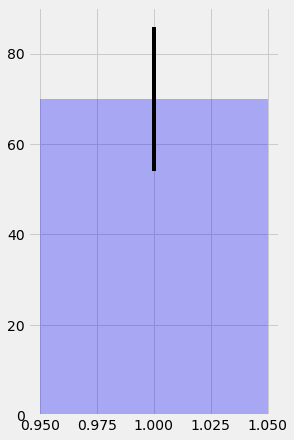

In [136]:
plt.rcParams['figure.figsize'] =(4,7)
#tick_locations = [value for value in x_axis]

plt.bar(x_axis, average_temp, color = 'blue', alpha =0.3, width=0.1, align='center', yerr=peaktopeak_temp[0])
plt.xticks(tick_locations,[(f' From {start_date} To {end_date}')], color ="black")
plt.title('Honolulu, Hawaii\nTrip Average Temperature', fontsize=15)
plt.ylabel("Temperature (F)")
plt.ytick(fontsize=14)
plt.xlim(-0.1,0.1)
plt.ylim(-5,100)

plt.savefig("./Images/bar.png")
plt.show()

### Daily Rainfall Average

In [101]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = (session.query(Measurement.station, Station.name,func.sum(Measurement.prcp),
                               Station.latitude,Station.longitude,Station.elevation)
                     .filter(Measurement.date>=start_date)
                     .filter(Measurement.date<=end_date)
                     .group_by(Measurement.station ==Station.station)
                     .order_by(func.sum(Measurement.prcp)
                    .desc())
                     .all())

total_rainfall_df = pd.DataFrame(total_rainfall,
                                columns=['station','name','total_prcp','latitude',
                                        'longitude', 'elevation'])
total_rainfall_df 

,station,name,total_prcp,latitude,longitude,elevation
0,USC00519397,"KANEOHE 838.1, HI US",148.64,21.4234,-157.8015,14.6
1,USC00519397,"WAIKIKI 717.2, HI US",18.58,21.2716,-157.8168,3.0


### Daily Temperature Normals

In [102]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [104]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals =[]
# Set the start and end date of the trip
start_date = '2013-12-15'
end_date = '2013-12-23'

trip_days = ['12-15','12-16','12-17','12-18','12-19','12-20','12-21','12-22','12-23']

# Use the start and end date to create a range of dates
def daily_normals(date):
    sel =[func.min(Measurement.tobs),func.round(func.avg(Measurement.tobs),2),
         func.max(Measurement.tobs)]
    
    # Strip off the year and save a list of strings in the format %m-%d
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date)==date).all()


# Use the `daily_normals` function to calculate the normals for each date string 
for days in trip_days:
    normals.append(daily_normals(days)[0])
# and append the results to a list called `normals`.
normals

[(62.0, 71.34, 79.0),
 (60.0, 69.62, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91, 81.0),
 (67.0, 72.14, 78.0),
 (67.0, 71.13, 77.0),
 (61.0, 70.35, 78.0)]

In [106]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normal_df = pd.DataFrame(normals, columns=['min_temp','average_temp','max_temp'], index =trip_days)

trip_normal_df

,min_temp,average_temp,max_temp
12-15,62.0,71.34,79.0
12-16,60.0,69.62,82.0
12-17,63.0,70.64,77.0
12-18,63.0,71.28,77.0
12-19,67.0,72.00,78.0
12-20,65.0,72.91,81.0
12-21,67.0,72.14,78.0
12-22,67.0,71.13,77.0
12-23,61.0,70.35,78.0


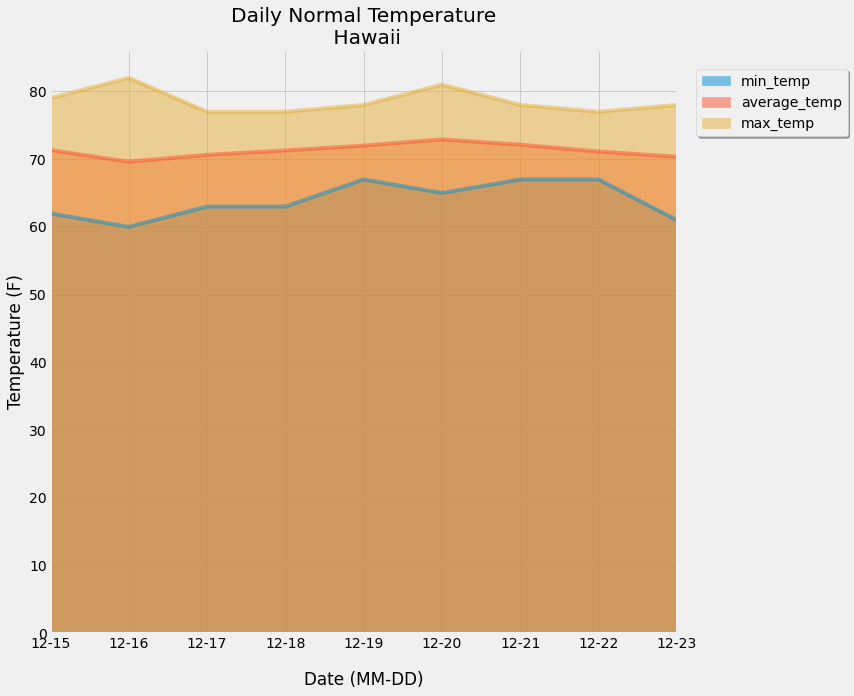

In [139]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normal_df.plot.area(stacked=False, alpha=0.5,figsize=(10,10));
#plt.figure(figsize=(10,15))
plt.xlabel('Date (MM-DD)',labelpad=20)
plt.ylabel('Temperature (F)')
plt.title('Daily Normal Temperature\n Hawaii')
plt.gca().legend(loc='center left',shadow=True, bbox_to_anchor=(1.02,0.91),)

plt.savefig("./Images/Area_plot.png")
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

## Close Session